In [1]:
# CCS, Current control
import time
from typing import Tuple, Optional, List, Type

import gymnasium as gym
from matplotlib.pylab import seed
import numpy as np
import torch as th
import torch.nn as nn
import matplotlib.pyplot as plt

from gymnasium import ObservationWrapper
from gymnasium.wrappers import TimeLimit
from gymnasium.spaces import Box

from stable_baselines3 import DDPG, TD3
from stable_baselines3.common.policies import BaseModel
from stable_baselines3.common.preprocessing import get_action_dim
from stable_baselines3.common.torch_layers import BaseFeaturesExtractor
from stable_baselines3.common.utils import update_learning_rate
from stable_baselines3.td3.policies import Actor, TD3Policy

import gym_electric_motor as gem
from gym_electric_motor.physical_systems import ConstantSpeedLoad
from gym_electric_motor.physical_system_wrappers import CosSinProcessor, DeadTimeProcessor, DqToAbcActionProcessor

from dq_to_abc_action_processor import DqToAbcActionProcessor # type: ignore
from gym_electric_motor.reference_generators import MultipleReferenceGenerator, ConstReferenceGenerator, WienerProcessReferenceGenerator, StepReferenceGenerator, SubepisodedReferenceGenerator
from gym_electric_motor import RewardFunction

from gym_electric_motor.utils import set_state_array
import warnings
import pickle
from gym_electric_motor import ReferenceGenerator
from gym_electric_motor.utils import instantiate
import random
from gym_electric_motor.random_component import RandomComponent
from stable_baselines3.common.noise import NormalActionNoise
from typing import Callable

import tensorboard
from scipy import signal

In [2]:
class FeatureWrapper(ObservationWrapper):
    """
    Wrapper class which wraps the environment to change its observation from a tuple to a flat vector.
    """
    def __init__(self, env):
        """
        Changes the observation space from a tuple to a flat vector
        
        Args:
            env(GEM env): GEM environment to wrap
        """
        super(FeatureWrapper, self).__init__(env)
        state_space = self.env.observation_space[0]
        ref_space = self.env.observation_space[1]
    
        new_low = np.concatenate((state_space.low,
                                  ref_space.low))
        new_high = np.concatenate((state_space.high,
                                   ref_space.high))

        self.observation_space = Box(new_low, new_high)

    def observation(self, observation):
        """
        Gets called at each return of an observation.
        
        """
        observation = np.concatenate((observation[0],
                                      observation[1],
                                      ))
        return observation

In [3]:
class LastActionWrapper(gym.Wrapper):
    def __init__(self, env):
        super(LastActionWrapper, self).__init__(env)
        state_space = self.env.observation_space
        action_space = self.env.action_space

        new_low = np.concatenate((state_space.low,
                                  action_space.low))
        new_high = np.concatenate((state_space.high,
                                   action_space.high))

        self.observation_space = Box(new_low, new_high)
        
# fill last action with zeros
    def reset(self, seed = 42, **kwargs):
        super().reset(seed = seed)
        observation, info = self.env.reset(**kwargs)
        self.last_action = np.zeros(self.action_space.shape[0], dtype=np.float32)
        return np.concatenate((observation, self.last_action)), info

# put action to the last action
# ["i_sd", "i_sq", "omega", "i_e", "cos(epsilon)", "sin(epsilon)", "id_ref", "iq_ref", "if_ref", "3 actions"]
    def step(self, action):
        observation, reward, terminated, truncated, info = self.env.step(action)
        self.last_action = action
        return np.concatenate((observation, self.last_action)), reward, terminated, truncated, info

In [4]:
class CustomizedReward(RewardFunction):
    
    def __init__(self, reward_weights=None, normed_reward_weights=False, violation_reward=None,
                 gamma=0.9, reward_power=1, bias=0.0):

        super().__init__()
        self._n = reward_power
        self._reward_weights = reward_weights
        self._state_length = None
        self._normed = normed_reward_weights
        self._gamma = gamma
        self._bias = bias
        self._violation_reward = violation_reward

    def set_modules(self, physical_system, reference_generator, constraint_monitor):
        super().set_modules(physical_system, reference_generator, constraint_monitor)
        ps = physical_system
        #self._state_length = ps.state_space.high - ps.state_space.low
        self._n = set_state_array(self._n, ps.state_names)
        referenced_states = reference_generator.referenced_states
        # if self._reward_weights is None:
        #     # If there are any referenced states reward weights are equally distributed over them
        #     if np.any(referenced_states):
        #         reward_weights = dict.fromkeys(
        #             np.array(physical_system.state_names)[referenced_states],
        #             1 / len(np.array(physical_system.state_names)[referenced_states])
        #         )
        #     # If no referenced states and no reward weights passed, uniform reward over all states
        #     else:
        #         reward_weights = dict.fromkeys(
        #             np.array(physical_system.state_names),
        #             1 / len(np.array(physical_system.state_names))
        #         )
        # else:
        reward_weights = self._reward_weights
        self._reward_weights = set_state_array(reward_weights, ps.state_names)

        if sum(self._reward_weights) == 0:
            warnings.warn("All reward weights sum up to zero", Warning, stacklevel=2)
        rw_sum = sum(self._reward_weights)
        if self._normed:
            if self._bias == 'positive':
                self._bias = 1
            self._reward_weights = self._reward_weights / rw_sum
            self.reward_range = (-1 + self._bias, self._bias)
        else:
            if self._bias == 'positive':
                self._bias = rw_sum
            self.reward_range = (-rw_sum + self._bias, self._bias)

        if self._violation_reward is None:
            self._violation_reward = min(self.reward_range[0] / (1.0 - self._gamma), 0)

    def reward(self, state, reference, k=None, action=None, violation_degree=0.0):
        return (1.0 - violation_degree) * self._wse_reward(state, reference) \
            + violation_degree * self._wse_reward(state, reference)

    # Reward design
    def _wse_reward(self, state, reference):
        i_limit = 1
        i_f = state[7]
        i_applied = np.sqrt(state[5]**2 + state[6]**2)

        E_d = abs(reference[5] - state[5])
        E_q = abs(reference[6] - state[6])
        E_f = abs(reference[7] - state[7])
        E_mean = E_d + E_q + E_f*2

        if (i_f > i_limit): # [-2, > -2]
            R_tot = -1 - i_f
        
        elif (i_applied > i_limit): #[-1.1, > -1.1]
            R_tot = -0.1 - i_applied
        
        elif (i_f < 0): #[-1, > -1]
            R_tot = -1 + i_f
        
        else:
            R_tot = (1 - self._gamma) * (1 - E_mean) # [-0.8, 0.8]

        return R_tot # check reward calculation

In [5]:
class CusConstReferenceGenerator(ReferenceGenerator): # Original generator has some issue with []
    """
    Reference Generator that generates a constant reference for a single state variable.
    """
    def __init__(self, reference_value, reference_state='i_e', **kwargs):
        """
        Args:
            reference_value(float): Normalized Value for the const reference.
            reference_state(string): Name of the state to reference
            kwargs(dict): Arguments passed to the superclass ReferenceGenerator.
        """
        super().__init__(**kwargs)
        self._reference_value = reference_value
        self._reference_state = reference_state.lower()
        self.reference_space = Box(np.array([reference_value]), np.array([reference_value]), dtype=np.float64)
        self._reference_names = [self._reference_state]

    def set_modules(self, physical_system):
        # docstring from superclass
        super().set_modules(physical_system)
        self._referenced_states = set_state_array(
            {self._reference_state: 1}, physical_system.state_names
        ).astype(bool)

    def get_reference(self, *_, **__):
        # docstring from superclass
        reference = np.zeros_like(self._referenced_states, dtype=float)
        reference[self._referenced_states] = self._reference_value
        return reference

    def get_reference_observation(self, *_, **__):
        # docstring from superclass
        return np.array([self._reference_value])
    
    def reset(self, initial_state=None, initial_reference=None):
        self._reference_value = np.round(random.choice(np.arange(0, 0.9, 0.1)), 1)
        # self._reference_value = random.choice([0.2, 0.5, 0.8])
        return self.get_reference(initial_state), self.get_reference_observation(initial_state), None

In [6]:
# write a costum callback to record the training progress
from stable_baselines3.common.callbacks import BaseCallback
class TrainingLogger(BaseCallback):
    """
    A custom callback that derives from ``BaseCallback``.

    :param verbose: Verbosity level: 0 for no output, 1 for info messages, 2 for debug messages
    """
    def __init__(self, verbose: int = 0):
        super().__init__(verbose)
        # Those variables will be accessible in the callback
        # (they are defined in the base class)
        # The RL model
        # self.model = None  # type: BaseAlgorithm
        # An alias for self.model.get_env(), the environment used for training
        # self.training_env # type: VecEnv
        # Number of time the callback was called
        # self.n_calls = 0  # type: int
        # num_timesteps = n_envs * n times env.step() was called
        # self.num_timesteps = 0  # type: int
        # local and global variables
        # self.locals = {}  # type: Dict[str, Any]
        # self.globals = {}  # type: Dict[str, Any]
        # The logger object, used to report things in the terminal
        # self.logger # type: stable_baselines3.common.logger.Logger
        # Sometimes, for event callback, it is useful
        # to have access to the parent object
        # self.parent = None  # type: Optional[BaseCallback]
        
    def _on_training_start(self) -> None:
        """
        This method is called before the first rollout starts.
        """
        self.rewards = np.zeros(self.model._total_timesteps)

        pass

    def _on_rollout_start(self) -> None:
        """
        A rollout is the collection of environment interaction
        using the current policy.
        This event is triggered before collecting new samples.
        """
        pass

    def _on_step(self) -> bool:
        """
        This method will be called by the model after each call to `env.step()`.

        For child callback (of an `EventCallback`), this will be called
        when the event is triggered.

        :return: If the callback returns False, training is aborted early.
        """
        #print('1')
        self.rewards[self.num_timesteps - 1] = self.locals['rewards']
        self.logger.record("reward", np.mean(self.rewards[:self.num_timesteps+1]))
        #calculate the recursive mean reward

        return True

    def _on_rollout_end(self) -> None:
        """
        This event is triggered before updating the policy.
        """
        pass

    def _on_training_end(self) -> None:
        """
        This event is triggered before exiting the `learn()` method.
        """
        pass

In [7]:
motor_env_id = "Cont-CC-EESM-v0"
tau = 1e-4    # The duration of each sampling step
motor_type = 'EESM'

In [8]:
motor_parameter = {
        'p': 2,
        'l_d': 3.78e-3,
        'l_q': 1.21e-3,
        'l_m': 40e-3, 
        'l_e': 870e-3,
        'j_rotor': 0.3883,
        'r_s': 123e-3,
        'r_e': 15.6,
        'k': 0.057,
    }

limit_values = dict(
    omega = 7e+3*np.pi/30,
    i = 31.25,
    u = 200,
    u_e = 200,
    i_e = 6.25,
    )

nominal_values=dict(
    omega = 2e+3*np.pi/30,  # angular velocity in rad/s
    i = 25,                   # motor current in amps
    u = 200,                  # nominal voltage in volts
    u_e = 200,
    i_e = 5,
    )

# EESM_init={'random_init': 'uniform', }

eesm_init = {
    'states': {
        'i_sd' : 0.,
        'i_sq' : 0.,
        'i_e' : 0.,
        'epsilon' : 0.,
        }
    }

# eesm_init = EESM_init

physical_system_wrappers = [
    # Wrapped directly around the physical system
    CosSinProcessor(angle='epsilon'),
    DqToAbcActionProcessor.make('EESM'),
    DeadTimeProcessor(steps=1) # Only use DeadTimeWrapper after you have implemented a last action concatinator for the state
    # Wrapped around the CosSinProcessor. Therefore, the generated states (cos and sin) can be accessed.
]

#load_init = {'states': {'omega': 4000*2*np.pi/60 * 0.2}}
load_init={'random_init': 'uniform', }
load = ConstantSpeedLoad(
    load_initializer=load_init 
)

d_generator = StepReferenceGenerator(reference_state = 'i_sd')
q_generator = StepReferenceGenerator(reference_state = 'i_sq')
f_generator = CusConstReferenceGenerator(reference_state = 'i_e', reference_value = 0.5)

ref_gen = MultipleReferenceGenerator([d_generator, q_generator, f_generator])

reward_function = CustomizedReward(
    reward_weights = dict(i_sd = 1, i_sq = 1, i_e = 1),
    reward_power = 1, # just to be compactable with original reward design
    violation_reward = -1, # not applicable here, the violation reward will come from reward design
    gamma = 0.9,
    normed_reward_weights = False # Otherwise weights will be normed automatically to sum up to 1.
    )

env = gem.make(  
    motor_env_id,
    motor=dict(
        motor_parameter=motor_parameter,
        limit_values=limit_values,
        nominal_values=nominal_values,
        motor_initializer=eesm_init,
    ),
    load=load,
    tau=tau,
    # ode_solver='euler',
    physical_system_wrappers=physical_system_wrappers, # Pass the Physical System Wrappers
    state_filter=["i_sd", "i_sq", "omega", "i_e", "cos(epsilon)", "sin(epsilon)"], # this is connected to index in validation session
    supply=dict(u_nominal=200),
    reward_function = reward_function,
    reference_generator = ref_gen,
    )

env= TimeLimit(LastActionWrapper(FeatureWrapper(env)), max_episode_steps = 5000)

Transforming r_e, l_m and l_e to stator side.
To specify stator-side quantities, make use of keys r_E, l_M and l_E instead.


In [9]:
def Noise_schedule(initial_value: float) -> Callable[[float], float]:
    # standard deviaiton will be changing over time
    """
    Linear learning rate schedule.

    :param initial_value: Initial learning rate.
    :return: schedule that computes
      current learning rate depending on remaining progress
    """
    def Decay_noise(_current_progress_remaining: float) -> float:

        if (_current_progress_remaining >= 0.75): # initial phase
            sigma = initial_value
        elif (_current_progress_remaining < 0.75) and (_current_progress_remaining >= 0.5): # exploration phase
            m = -2.8
            c = 8 * initial_value # c = 2.4
            sigma = (m * _current_progress_remaining) + c
        elif (_current_progress_remaining < 0.5): # exploitation phase
            coeff = initial_value/300 # A coefficient = 0.001
            k = -13.82
            sigma_sd = coeff[0] * np.exp(-k * _current_progress_remaining)
            sigma_sq = coeff[1] * np.exp(-k * _current_progress_remaining)
            sigma_e = coeff[2] * np.exp(-k * _current_progress_remaining)
            sigma = np.concatenate((sigma_sd, sigma_sq, sigma_e))

        N_actions = env.action_space.shape[-1]
        action_noise = NormalActionNoise(mean=np.zeros(N_actions), sigma = sigma)

        return action_noise

    return Decay_noise

In [10]:
class CustomDDPG(DDPG):
    def __init__(self, policy, env, *args, actor_lr=1e-5, critic_lr=1e-4, action_noise, **kwargs):
    #def __init__(self, policy, env, *args, actor_lr=1e-5, critic_lr=1e-4, **kwargs):
        super().__init__(policy, env, *args, **kwargs)
        self.actor_lr = actor_lr
        self.critic_lr = critic_lr
        self.action_noise = action_noise(self._current_progress_remaining)
        
    def _update_learning_rate(self, optimizers):
        """
                Costum function to update actor and critic with different learning rates.
                Based on https://github.com/DLR-RM/stable-baselines3/issues/338
                """
        actor_optimizer, critic_optimizer = optimizers

        update_learning_rate(actor_optimizer, self.actor_lr)
        update_learning_rate(critic_optimizer, self.critic_lr)

In [11]:
def create_network(input_dim, hidden_sizes, output_dim, activations):
    """
    Create a neural network with customizable layers, sizes, and activation functions.

    Args:
    - input_dim (int): The size of the input layer.
    - hidden_sizes (list): List of integers representing the sizes of each hidden layer.
    - output_dim (int): The size of the output layer.
    - activations (list): List of tuples where each tuple contains the activation function
                          name as the first element and any parameters as subsequent elements.
                          Pass None for layers without activation.

    Returns:
    - network (nn.Sequential): The created neural network.
    """

    layers = []
    
    # Input layer

    #m = nn.Linear(20, 30) ==> 20 is input, 30 is output
    #input = torch.randn(128, 20) ==> 128 batch, 20 features
    #output = m(input)
    #print(output.size())
    #torch.Size([128, 30]) ==> 128 batch, 30 features

    layers.append(nn.Linear(input_dim, hidden_sizes[0])) # ???
    
    # Activation function for the first hidden layer
    if activations[0] is not None:
        activation, *params = activations[0]
        act_func = getattr(nn, activation)(*params)
        layers.append(act_func)

    # Hidden layers
    for i in range(1, len(hidden_sizes)):
        layers.append(nn.Linear(hidden_sizes[i - 1], hidden_sizes[i]))

        # Activation function
        if activations[i] is not None:
            activation, *params = activations[i]
            act_func = getattr(nn, activation)(*params)
            layers.append(act_func)

    # Output layer
    layers.append(nn.Linear(hidden_sizes[-1], output_dim))

    # Activation function for output layer
    if activations[-1] is not None:
        activation, *params = activations[-1]
        act_func = getattr(nn, activation)(*params)
        layers.append(act_func)

    return nn.Sequential(*layers)

state_dim = env.observation_space.shape[0]
action_dim = env.action_space.shape[0]

actor_activations = [('LeakyReLU', 0.2), ('LeakyReLU', 0.2), ('Tanh',)]
critic_activations = [('LeakyReLU', 0.2), ('LeakyReLU', 0.2), ('LeakyReLU', 0.2), ('LeakyReLU', 0.2), ('LeakyReLU', 0.2), None]

actor_network = create_network(
    input_dim = state_dim,
    output_dim = action_dim,
    hidden_sizes =[128, 128],
    activations=actor_activations)

critic_network = create_network(
    input_dim=state_dim + action_dim,
    output_dim=1,
    hidden_sizes= [128, 128, 128, 128, 128],
    activations=critic_activations)

In [12]:
class CustomActor(Actor):
    """
    Actor network (policy) for TD3.
    """
    def __init__(self, *args, **kwargs):
        super(CustomActor, self).__init__(*args, **kwargs)
        # Define custom network with Dropout
        # WARNING: it must end with a tanh activation to squash the output
        #self.mu = nn.Sequential(...)
        self.mu = actor_network

class CustomContinuousCritic(BaseModel):
    """
    Critic network(s) for DDPG/SAC/TD3.
    """
    def __init__(
        self,
        observation_space: gym.spaces.Space,
        action_space: gym.spaces.Space,
        net_arch: List[int],
        features_extractor: nn.Module,
        features_dim: int,
        activation_fn: Type[nn.Module] = nn.ReLU,
        normalize_images: bool = True,
        n_critics: int = 2,
        share_features_extractor: bool = True,
    ):
        super().__init__(
            observation_space,
            action_space,
            features_extractor=features_extractor,
            normalize_images=normalize_images,
        )

        action_dim = get_action_dim(self.action_space)

        self.share_features_extractor = share_features_extractor
        self.n_critics = n_critics
        self.q_networks = []
        for idx in range(n_critics):
            # q_net = create_mlp(features_dim + action_dim, 1, net_arch, activation_fn)
            # Define critic with Dropout here
            q_net = critic_network
            self.add_module(f"qf{idx}", q_net)
            self.q_networks.append(q_net)

    def forward(self, obs: th.Tensor, actions: th.Tensor) -> Tuple[th.Tensor, ...]:
        # Learn the features extractor using the policy loss only
        # when the features_extractor is shared with the actor
        with th.set_grad_enabled(not self.share_features_extractor):
            features = self.extract_features(obs, self.features_extractor)
        qvalue_input = th.cat([features, actions], dim=1)
        return tuple(q_net(qvalue_input) for q_net in self.q_networks)

    def q1_forward(self, obs: th.Tensor, actions: th.Tensor) -> th.Tensor:
        """
        Only predict the Q-value using the first network.
        This allows to reduce computation when all the estimates are not needed
        (e.g. when updating the policy in TD3).
        """
        with th.no_grad():
            features = self.extract_features(obs, self.features_extractor)
        return self.q_networks[0](th.cat([features, actions], dim=1))

class CustomTD3Policy(TD3Policy):
    def __init__(self, *args, **kwargs):
        #actor_network = kwargs.pop('actor_network')
        #critic_network = kwargs.pop('critic_network')
        
        super(CustomTD3Policy, self).__init__(*args, **kwargs)
        #self.actor_network = actor_network
        #self.critic_network = critic_network

    def make_actor(self, features_extractor: Optional[BaseFeaturesExtractor] = None) -> CustomActor:
        actor_kwargs = self._update_features_extractor(self.actor_kwargs, features_extractor)
        return CustomActor(**actor_kwargs).to(self.device)

    def make_critic(self, features_extractor: Optional[BaseFeaturesExtractor] = None) -> CustomContinuousCritic:
        critic_kwargs = self._update_features_extractor(self.critic_kwargs, features_extractor)
        return CustomContinuousCritic(**critic_kwargs).to(self.device)

TD3.policy_aliases["CustomTD3Policy"] = CustomTD3Policy

In [13]:
simulation_time = 90 # seconds
nb_steps = int(simulation_time//tau)
# nb_steps = 25600 # number of training steps
learning_starts = 5000 # memory warmup
buffer_size = nb_steps + learning_starts #number of old observation steps saved
train_freq = 1 # prediction network gets an update each train_freq's step
batch_size = 256 # mini batch size drawn at each update step
gamma = 0.9
verbose = 1 # verbosity of stable-basline's prints
lr_actor = 1e-5
lr_critic = 1e-4
action_noise = Noise_schedule(np.array([0.3, 0.3, 0.3]))

In [14]:
from stable_baselines3.common.logger import configure

policy_kwargs = dict(optimizer_class=th.optim.Adam,)

agent = CustomDDPG("CustomTD3Policy", env, buffer_size=buffer_size, learning_starts=learning_starts ,train_freq=train_freq, 
            batch_size=batch_size, gamma=gamma, policy_kwargs=policy_kwargs, 
            verbose=verbose, actor_lr=lr_actor, critic_lr=lr_critic, action_noise = action_noise)

start_time = time.time()

agent.learn(total_timesteps = nb_steps, callback=TrainingLogger())

total_time = time.time() - start_time
print(f"Batch size 1 total time: {total_time // 60} minutes, {total_time % 60} seconds")

Logging to /Users/nyinyia/Documents/GIT/log/20240806_CCN_06_8
Using cpu device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
---------------------------------
| reward             | -0.651   |
| rollout/           |          |
|    ep_len_mean     | 27.8     |
|    ep_rew_mean     | -18.2    |
| time/              |          |
|    episodes        | 4        |
|    fps             | 2118     |
|    time_elapsed    | 0        |
|    total_timesteps | 111      |
---------------------------------
---------------------------------
| reward             | -0.683   |
| rollout/           |          |
|    ep_len_mean     | 31.4     |
|    ep_rew_mean     | -21.5    |
| time/              |          |
|    episodes        | 8        |
|    fps             | 2238     |
|    time_elapsed    | 0        |
|    total_timesteps | 251      |
---------------------------------
---------------------------------
| reward             | -0.632   |
| rollout/           |      

<ipython-input-6-05f3d06c90a3>:57: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  self.rewards[self.num_timesteps - 1] = self.locals['rewards']


---------------------------------
| reward             | -0.656   |
| rollout/           |          |
|    ep_len_mean     | 25.6     |
|    ep_rew_mean     | -16.9    |
| time/              |          |
|    episodes        | 20       |
|    fps             | 2166     |
|    time_elapsed    | 0        |
|    total_timesteps | 513      |
---------------------------------
---------------------------------
| reward             | -0.641   |
| rollout/           |          |
|    ep_len_mean     | 23.5     |
|    ep_rew_mean     | -15.1    |
| time/              |          |
|    episodes        | 24       |
|    fps             | 2134     |
|    time_elapsed    | 0        |
|    total_timesteps | 563      |
---------------------------------
---------------------------------
| reward             | -0.648   |
| rollout/           |          |
|    ep_len_mean     | 23       |
|    ep_rew_mean     | -14.9    |
| time/              |          |
|    episodes        | 28       |
|    fps      

In [15]:
obs, _ = env.reset(seed = 1)

# Take trained agent and loop over environment
i_sd = []
i_sq = []
i_f = []
i_sd_ref = []
i_sq_ref = []
i_f_ref = []
omegas = []
action_stored = []
rewards_stored = []

# ["i_sd", "i_sq", "omega", "i_f", "cos(epsilon)", "sin(epsilon)"], 3 ref, 3actions

for i in range(5000):
    action, _states = agent.predict(obs, deterministic=True)
    obs, rewards, terminated, truncated, info = env.step(action)
    done = terminated or truncated

    # without epsilon
    i_sd_idx = obs[0]
    i_sq_idx = obs[1]
    omega_idx = obs[2]
    i_f_idx = obs[3]
    i_sd_ref_idx = obs[6]
    i_sq_ref_idx = obs[7]
    i_f_ref_idx = obs[8]

    i_sd.append(i_sd_idx)
    i_sq.append(i_sq_idx)
    i_f.append(i_f_idx)
    i_sd_ref.append(i_sd_ref_idx)
    i_sq_ref.append(i_sq_ref_idx)
    i_f_ref.append(i_f_ref_idx)
    omegas.append(omega_idx)
    action_stored.append(action)
    rewards_stored.append(rewards)

    if done:
        obs,_ = env.reset()

action_record = np.array(action_stored)
rewards_record = np.array(rewards_stored)

In [16]:
Supplied_Umax = 200
u_sd = action_record[:,0]
u_sq = action_record[:,1]
u_f = action_record[:,2]

V_sv = np.sqrt(np.array([u_sd])**2 + np.array([u_sq])**2) # supplied stator voltage

real_usd = action_record[:,0] * Supplied_Umax
real_usq = action_record[:,1] * Supplied_Umax
real_uf = action_record[:,2] * Supplied_Umax
Real_U = np.sqrt(real_usd**2 + real_usq**2) # supplied stator voltage, physical value

Ref_tot = np.sqrt(np.array([i_sd_ref])**2 + np.array([i_sq_ref])**2) # reference stator current
feedback = np.sqrt(np.array([i_sd])**2 + np.array([i_sq])**2) # feedback stator current
constraint = (np.array([i_sd])**2 + np.array([i_sq])**2)

Supplied_Imax = np.array([31.25])
Supplied_Ifmax = np.array([6.25])
real_isd = i_sd * Supplied_Imax
real_isq = i_sq * Supplied_Imax
real_if = i_f * Supplied_Ifmax
Real_I = np.sqrt(real_isd**2 + real_isq**2)

# Reward Manually # just for different validation profile
gamma = 0.9
R_manual = np.zeros(len(i_sd))
Ed = np.zeros(len(i_sd))
Eq = np.zeros(len(i_sd))
Ef = np.zeros(len(i_sd))
E_avg = np.zeros(len(i_sd))
E_tol = 0.1

for rr in range(len(i_sd)):
    Ed[rr] = abs(i_sd_ref[rr] - i_sd[rr])
    Eq[rr] = abs(i_sq_ref[rr] - i_sq[rr])
    Ef[rr] = abs(i_f_ref[rr] - i_f[rr])
    E_avg[rr] = (Ed[rr] + Eq[rr] + Ef[rr])/3

    if (Ed[rr] > E_tol) or (Eq[rr] > E_tol) or (Ef[rr] > E_tol):
        R_manual[rr] = (1- gamma) * (1 - 2*E_avg[rr])

    elif (Ed[rr] < E_tol) and (Eq[rr] < E_tol) and (Ef[rr] < E_tol):
        R_manual[rr] = (1- gamma) * (1 - E_avg[rr])


# What is happening with resetting the env, just to go through what's wrong, not important
index_loc = np.where(rewards_record < -1)[0]
i_stator_reset = feedback[0, index_loc]
v_stator_reset = V_sv[0, index_loc]
i_field_reset = np.array([i_f])[0, index_loc]
v_field_reset = np.array([u_f])[0, index_loc]
i_constraint = constraint[0, index_loc]

Reset_con = np.concatenate((index_loc.reshape(-1,1), 
                            i_stator_reset.reshape(-1,1),
                            v_stator_reset.reshape(-1,1), 
                            i_field_reset.reshape(-1,1),
                            v_field_reset.reshape(-1,1),
                            i_constraint.reshape(-1,1)), axis = 1)

np.set_printoptions(precision=4, suppress=True, floatmode='fixed')
print(f'Reset Index     I_s        V_s       I_field     V_field    I_con \n {np.round(Reset_con, 4)}')

Reset Index     I_s        V_s       I_field     V_field    I_con 
 []


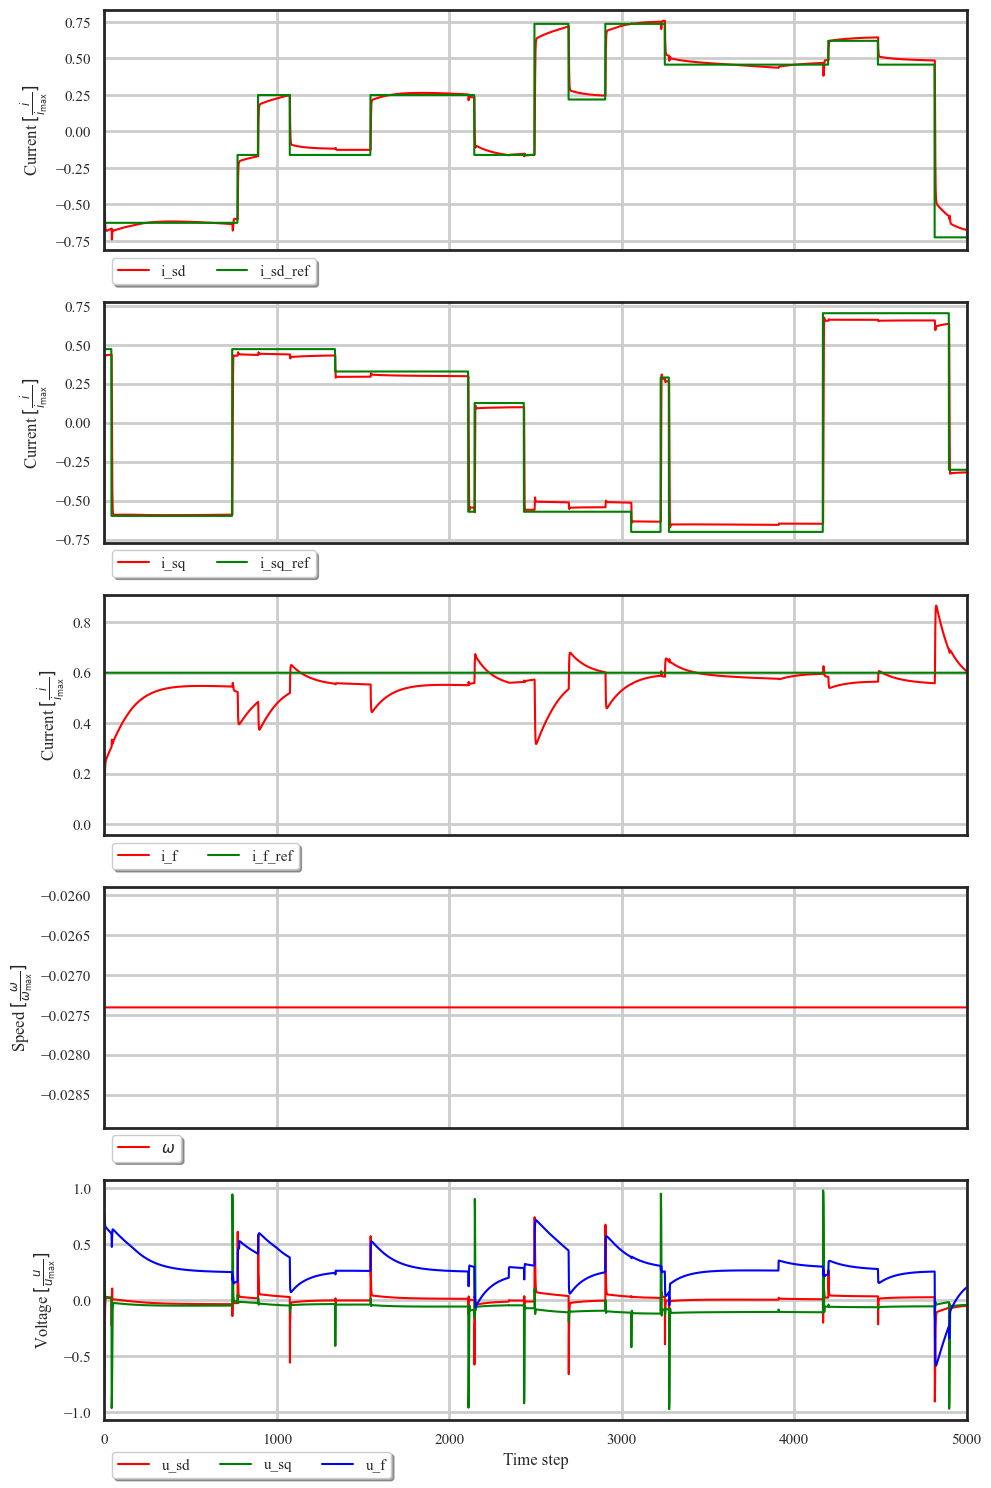

In [17]:
time_points = range(len(i_sd))
import seaborn as sns
sns.set_theme(context='notebook', style='white', palette='deep', font='Times New Roman', font_scale=1, color_codes=True, rc={'axes.linewidth': 2, 'grid.linewidth': 2})
fig, (ax1, ax2, ax3, ax4,  ax5) = plt.subplots(5, 1, figsize=(10, 15), sharex=True)

ax1.plot(time_points, i_sd, label='i_sd', color = 'red')
ax1.plot(time_points, i_sd_ref, label='i_sd_ref', color = 'green')
ax1.set_ylabel(r'Current $[\frac{i}{i_{\text{max}}}]$')
ax1.legend(loc='upper left', bbox_to_anchor=(0, 0),
          fancybox=True, shadow=True, ncol = 2)
ax1.grid()

ax2.plot(time_points, i_sq, label='i_sq', color = 'red')
ax2.plot(time_points, i_sq_ref, label='i_sq_ref', color = 'green')
ax2.set_ylabel(r'Current $[\frac{i}{i_{\text{max}}}]$')
ax2.legend(loc='upper left', bbox_to_anchor=(0, 0),
          fancybox=True, shadow=True, ncol=2)
ax2.grid()

ax3.plot(time_points, i_f, label='i_f', color = 'red')
ax3.plot(time_points, i_f_ref, label='i_f_ref', color = 'green')
ax3.set_ylabel(r'Current $[\frac{i}{i_{\text{max}}}]$')
ax3.legend(loc='upper left', bbox_to_anchor=(0, 0),
          fancybox=True, shadow=True, ncol=2)
ax3.grid()

ax4.plot(time_points, omegas, label = r'$\omega$', color = 'red')
ax4.set_ylabel(r'Speed $[\frac{\omega}{\omega_{\text{max}}}]$')
ax4.legend(loc='upper left', bbox_to_anchor=(0, 0),
          fancybox=True, shadow=True, ncol = 1)
ax4.grid()

ax5.plot(time_points, action_record[:,0], label='u_sd', color='red')
ax5.plot(time_points, action_record[:,1], label='u_sq', color='green')
ax5.plot(time_points, action_record[:,2], label='u_f', color='blue')
ax5.set_ylabel(r'Voltage $[\frac{u}{u_{\text{max}}}]$')
ax5.set_xlabel('Time step')
# ax4.set_ylim([-1,1])
ax5.set_xlim([0, len(i_sd)])
ax5.legend(loc='upper left', bbox_to_anchor=(0, -0.1),
          fancybox=True, shadow=True, ncol = 3)
ax5.grid()
# ax5.set_ylim([-1.5, 1.5])
# Adjust layout
plt.tight_layout()
plt.show()

In [18]:
obs, _ = env.reset(seed = 1)

# Take trained agent and loop over environment

i_sd = []
i_sq = []
i_f = []

i_sd_ref = []
i_sq_ref = []
i_f_ref = []
omegas = []
epsilon = []

action_stored = []
rewards_stored = []

# ["i_sd", "i_sq", "omega", "i_f", "cos(epsilon)", "sin(epsilon)"], 3 ref, 3actions

for i in range(5000):
    action, _states = agent.predict(obs, deterministic=True)
    obs, rewards, terminated, truncated, info = env.step(action)
    done = terminated or truncated

    # without epsilon
    i_sd_idx = obs[0]
    i_sq_idx = obs[1]
    omega_idx = obs[2]
    i_f_idx = obs[3]
    i_sd_ref_idx = obs[6]
    i_sq_ref_idx = obs[7]
    i_f_ref_idx = obs[8]

    i_sd.append(i_sd_idx)
    i_sq.append(i_sq_idx)
    i_f.append(i_f_idx)
    i_sd_ref.append(i_sd_ref_idx)
    i_sq_ref.append(i_sq_ref_idx)
    i_f_ref.append(i_f_ref_idx)
    omegas.append(omega_idx)
    action_stored.append(action)
    rewards_stored.append(rewards)

    if done:
        obs,_ = env.reset()

action_record = np.array(action_stored)
rewards_record = np.array(rewards_stored)

In [19]:
Supplied_Umax = 200
u_sd = action_record[:,0]
u_sq = action_record[:,1]
u_f = action_record[:,2]

V_sv = np.sqrt(np.array([u_sd])**2 + np.array([u_sq])**2)

real_usd = action_record[:,0] * Supplied_Umax
real_usq = action_record[:,1] * Supplied_Umax
real_uf = action_record[:,2] * Supplied_Umax
Real_U = np.sqrt(real_usd**2 + real_usq**2)

Ref_tot = np.sqrt(np.array([i_sd_ref])**2 + np.array([i_sq_ref])**2)
feedback = np.sqrt(np.array([i_sd])**2 + np.array([i_sq])**2)
constraint = (np.array([i_sd])**2 + np.array([i_sq])**2)

Supplied_Imax = np.array([31.25])
Supplied_Ifmax = np.array([6.25])
real_isd = i_sd * Supplied_Imax
real_isq = i_sq * Supplied_Imax
real_if = i_f * Supplied_Ifmax
Real_I = np.sqrt(real_isd**2 + real_isq**2)

# Reward Manually
gamma = 0.9
R_manual = np.zeros(len(i_sd))
Ed = np.zeros(len(i_sd))
Eq = np.zeros(len(i_sd))
Ef = np.zeros(len(i_sd))
E_avg = np.zeros(len(i_sd))
E_tol = 0.1

for rr in range(len(i_sd)):
    Ed[rr] = abs(i_sd_ref[rr] - i_sd[rr])
    Eq[rr] = abs(i_sq_ref[rr] - i_sq[rr])
    Ef[rr] = abs(i_f_ref[rr] - i_f[rr])
    E_avg[rr] = (Ed[rr] + Eq[rr] + Ef[rr])/3

    if (Ed[rr] > E_tol) or (Eq[rr] > E_tol) or (Ef[rr] > E_tol):
        R_manual[rr] = (1- gamma) * (1 - 2*E_avg[rr])

    elif (Ed[rr] < E_tol) and (Eq[rr] < E_tol) and (Ef[rr] < E_tol):
        R_manual[rr] = (1- gamma) * (1 - E_avg[rr])

# What is happening with resetting the env
index_loc = np.where(rewards_record < -1)[0]
i_stator_reset = feedback[0, index_loc]
v_stator_reset = V_sv[0, index_loc]
i_field_reset = np.array([i_f])[0, index_loc]
v_field_reset = np.array([u_f])[0, index_loc]
i_constraint = constraint[0, index_loc]

Reset_con = np.concatenate((index_loc.reshape(-1,1), 
                            i_stator_reset.reshape(-1,1),
                            v_stator_reset.reshape(-1,1), 
                            i_field_reset.reshape(-1,1),
                            v_field_reset.reshape(-1,1),
                            i_constraint.reshape(-1,1)), axis = 1)

np.set_printoptions(precision=4, suppress=True, floatmode='fixed')
print(f'Reset Index     I_s        V_s       I_field     V_field    I_con \n {np.round(Reset_con, 4)}')

Reset Index     I_s        V_s       I_field     V_field    I_con 
 [[681.0000   1.0348   0.1238   0.4769  -0.2031   1.0708]]


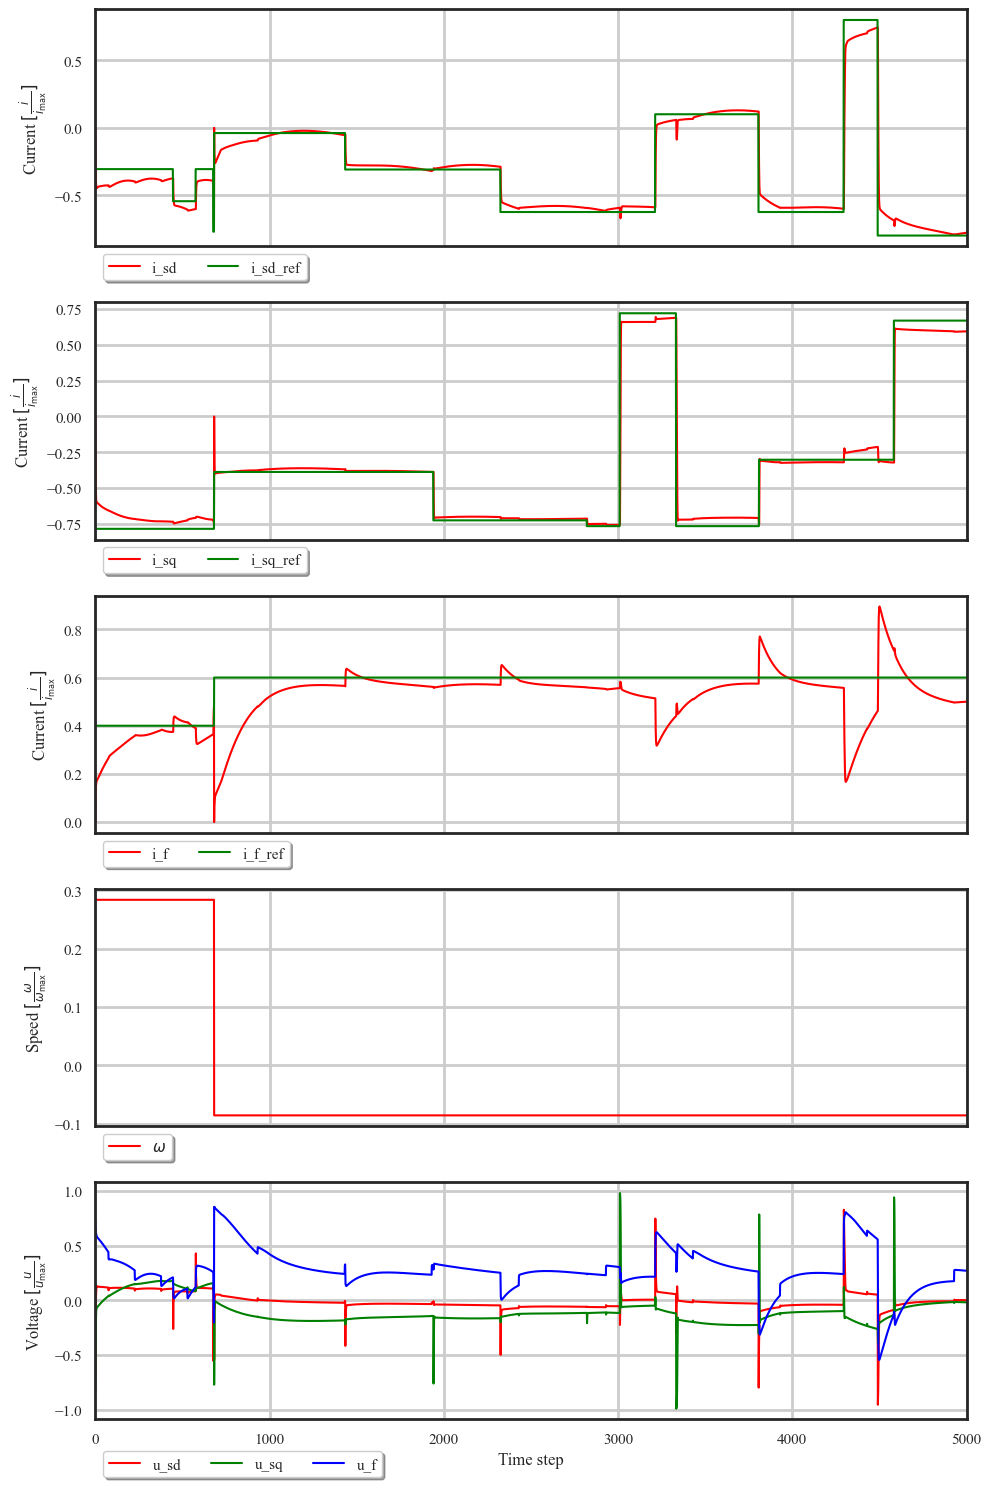

In [20]:
time_points = range(len(i_sd))
import seaborn as sns
sns.set_theme(context='notebook', style='white', palette='deep', font='Times New Roman', font_scale=1, color_codes=True, rc={'axes.linewidth': 2, 'grid.linewidth': 2})
fig, (ax1, ax2, ax3, ax4,  ax5) = plt.subplots(5, 1, figsize=(10, 15), sharex=True)

ax1.plot(time_points, i_sd, label='i_sd', color = 'red')
ax1.plot(time_points, i_sd_ref, label='i_sd_ref', color = 'green')
ax1.set_ylabel(r'Current $[\frac{i}{i_{\text{max}}}]$')
ax1.legend(loc='upper left', bbox_to_anchor=(0, 0),
          fancybox=True, shadow=True, ncol = 2)
ax1.grid()

ax2.plot(time_points, i_sq, label='i_sq', color = 'red')
ax2.plot(time_points, i_sq_ref, label='i_sq_ref', color = 'green')
ax2.set_ylabel(r'Current $[\frac{i}{i_{\text{max}}}]$')
ax2.legend(loc='upper left', bbox_to_anchor=(0, 0),
          fancybox=True, shadow=True, ncol=2)
ax2.grid()

ax3.plot(time_points, i_f, label='i_f', color = 'red')
ax3.plot(time_points, i_f_ref, label='i_f_ref', color = 'green')
ax3.set_ylabel(r'Current $[\frac{i}{i_{\text{max}}}]$')
ax3.legend(loc='upper left', bbox_to_anchor=(0, 0),
          fancybox=True, shadow=True, ncol=2)
ax3.grid()

ax4.plot(time_points, omegas, label = r'$\omega$', color = 'red')
ax4.set_ylabel(r'Speed $[\frac{\omega}{\omega_{\text{max}}}]$')
ax4.legend(loc='upper left', bbox_to_anchor=(0, 0),
          fancybox=True, shadow=True, ncol = 1)
ax4.grid()

ax5.plot(time_points, action_record[:,0], label='u_sd', color='red')
ax5.plot(time_points, action_record[:,1], label='u_sq', color='green')
ax5.plot(time_points, action_record[:,2], label='u_f', color='blue')
ax5.set_ylabel(r'Voltage $[\frac{u}{u_{\text{max}}}]$')
ax5.set_xlabel('Time step')
# ax4.set_ylim([-1,1])
ax5.set_xlim([0, len(i_sd)])
ax5.legend(loc='upper left', bbox_to_anchor=(0, -0.1),
          fancybox=True, shadow=True, ncol = 3)
ax5.grid()
# ax5.set_ylim([-1.5, 1.5])
# Adjust layout
plt.tight_layout()
plt.show()

In [21]:
obs, _ = env.reset(seed = 1)

# Take trained agent and loop over environment

i_sd = []
i_sq = []
i_f = []

i_sd_ref = []
i_sq_ref = []
i_f_ref = []
omegas = []
epsilon = []

action_stored = []
rewards_stored = []

# ["i_sd", "i_sq", "omega", "i_f", "cos(epsilon)", "sin(epsilon)"], 3 ref, 3actions

for i in range(5000):
    action, _states = agent.predict(obs, deterministic=True)
    obs, rewards, terminated, truncated, info = env.step(action)
    done = terminated or truncated

    # without epsilon
    i_sd_idx = obs[0]
    i_sq_idx = obs[1]
    omega_idx = obs[2]
    i_f_idx = obs[3]
    i_sd_ref_idx = obs[6]
    i_sq_ref_idx = obs[7]
    i_f_ref_idx = obs[8]

    i_sd.append(i_sd_idx)
    i_sq.append(i_sq_idx)
    i_f.append(i_f_idx)
    i_sd_ref.append(i_sd_ref_idx)
    i_sq_ref.append(i_sq_ref_idx)
    i_f_ref.append(i_f_ref_idx)
    omegas.append(omega_idx)
    action_stored.append(action)
    rewards_stored.append(rewards)

    # with epsilon
    # i_sd_idx = obs[0]
    # i_sq_idx = obs[1]
    # omega_idx = obs[2]
    # epsilon_idx = obs[3]
    # i_f_idx = obs[4]
    # i_f_ref_idx = obs[9]
    # i_sq_ref_idx = obs[8]
    # i_sd_ref_idx = obs[7]

    # i_sd.append(i_sd_idx)
    # i_sq.append(i_sq_idx)
    # i_f.append(i_f_idx)
    # i_sd_ref.append(i_sd_ref_idx)
    # i_sq_ref.append(i_sq_ref_idx)
    # i_f_ref.append(i_f_ref_idx)
    # omegas.append(omega_idx)
    # epsilon.append(epsilon_idx)
    # action_stored.append(action)
    # rewards_stored.append(rewards)

    if done:
        obs,_ = env.reset()

action_record = np.array(action_stored)
rewards_record = np.array(rewards_stored)

In [22]:
Supplied_Umax = 200
u_sd = action_record[:,0]
u_sq = action_record[:,1]
u_f = action_record[:,2]

V_sv = np.sqrt(np.array([u_sd])**2 + np.array([u_sq])**2)

real_usd = action_record[:,0] * Supplied_Umax
real_usq = action_record[:,1] * Supplied_Umax
real_uf = action_record[:,2] * Supplied_Umax
Real_U = np.sqrt(real_usd**2 + real_usq**2)

Ref_tot = np.sqrt(np.array([i_sd_ref])**2 + np.array([i_sq_ref])**2)
feedback = np.sqrt(np.array([i_sd])**2 + np.array([i_sq])**2)
constraint = (np.array([i_sd])**2 + np.array([i_sq])**2)

Supplied_Imax = np.array([31.25])
Supplied_Ifmax = np.array([6.25])
real_isd = i_sd * Supplied_Imax
real_isq = i_sq * Supplied_Imax
real_if = i_f * Supplied_Ifmax
Real_I = np.sqrt(real_isd**2 + real_isq**2)

# Reward Manually
gamma = 0.9
R_manual = np.zeros(len(i_sd))
Ed = np.zeros(len(i_sd))
Eq = np.zeros(len(i_sd))
Ef = np.zeros(len(i_sd))
E_avg = np.zeros(len(i_sd))
E_tol = 0.1

for rr in range(len(i_sd)):
    Ed[rr] = abs(i_sd_ref[rr] - i_sd[rr])
    Eq[rr] = abs(i_sq_ref[rr] - i_sq[rr])
    Ef[rr] = abs(i_f_ref[rr] - i_f[rr])
    E_avg[rr] = (Ed[rr] + Eq[rr] + Ef[rr])/3

    if (Ed[rr] > E_tol) or (Eq[rr] > E_tol) or (Ef[rr] > E_tol):
        R_manual[rr] = (1- gamma) * (1 - 2*E_avg[rr])

    elif (Ed[rr] < E_tol) and (Eq[rr] < E_tol) and (Ef[rr] < E_tol):
        R_manual[rr] = (1- gamma) * (1 - E_avg[rr])

# What is happening with resetting the env
index_loc = np.where(rewards_record < -1)[0]
i_stator_reset = feedback[0, index_loc]
v_stator_reset = V_sv[0, index_loc]
i_field_reset = np.array([i_f])[0, index_loc]
v_field_reset = np.array([u_f])[0, index_loc]
i_constraint = constraint[0, index_loc]

Reset_con = np.concatenate((index_loc.reshape(-1,1), 
                            i_stator_reset.reshape(-1,1),
                            v_stator_reset.reshape(-1,1), 
                            i_field_reset.reshape(-1,1),
                            v_field_reset.reshape(-1,1),
                            i_constraint.reshape(-1,1)), axis = 1)

np.set_printoptions(precision=4, suppress=True, floatmode='fixed')
print(f'Reset Index     I_s        V_s       I_field     V_field    I_con \n {np.round(Reset_con, 4)}')

Reset Index     I_s        V_s       I_field     V_field    I_con 
 []


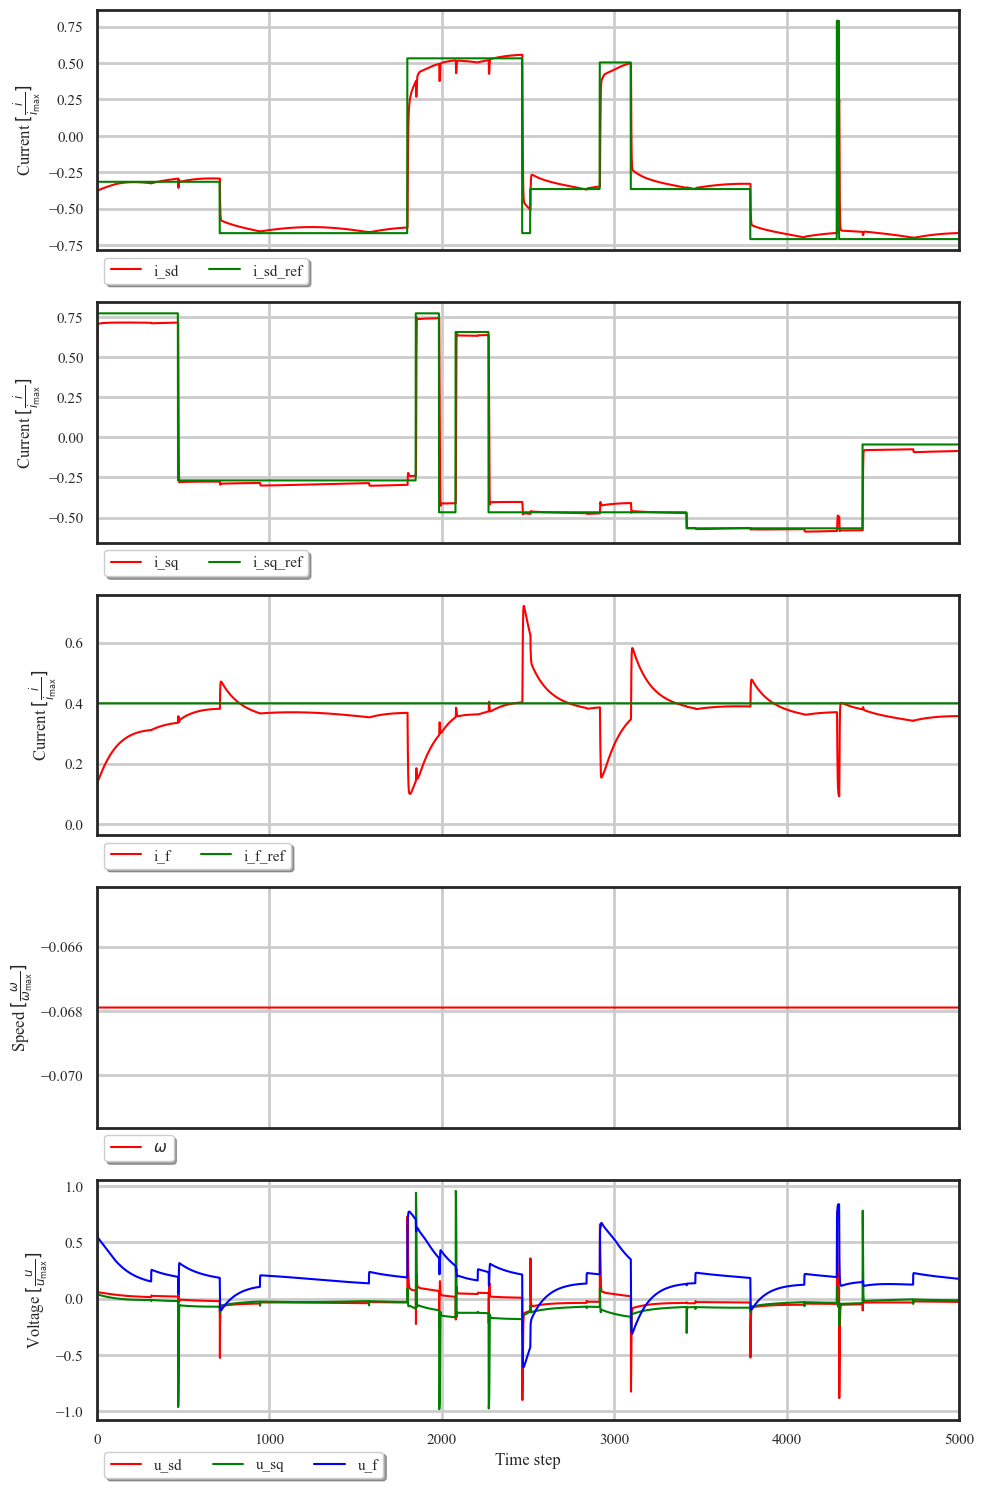

In [23]:
time_points = range(len(i_sd))
import seaborn as sns
sns.set_theme(context='notebook', style='white', palette='deep', font='Times New Roman', font_scale=1, color_codes=True, rc={'axes.linewidth': 2, 'grid.linewidth': 2})
fig, (ax1, ax2, ax3, ax4,  ax5) = plt.subplots(5, 1, figsize=(10, 15), sharex=True)

# First subplot for i_ds and i_ds_ref
ax1.plot(time_points, i_sd, label='i_sd', color = 'red')
ax1.plot(time_points, i_sd_ref, label='i_sd_ref', color = 'green')
ax1.set_ylabel(r'Current $[\frac{i}{i_{\text{max}}}]$')
ax1.legend(loc='upper left', bbox_to_anchor=(0, 0),
          fancybox=True, shadow=True, ncol = 2)
ax1.grid()

# Second subplot for i_qs and i_qs_ref
ax2.plot(time_points, i_sq, label='i_sq', color = 'red')
ax2.plot(time_points, i_sq_ref, label='i_sq_ref', color = 'green')
ax2.set_ylabel(r'Current $[\frac{i}{i_{\text{max}}}]$')
ax2.legend(loc='upper left', bbox_to_anchor=(0, 0),
          fancybox=True, shadow=True, ncol=2)
ax2.grid()

ax3.plot(time_points, i_f, label='i_f', color = 'red')
ax3.plot(time_points, i_f_ref, label='i_f_ref', color = 'green')
ax3.set_ylabel(r'Current $[\frac{i}{i_{\text{max}}}]$')
ax3.legend(loc='upper left', bbox_to_anchor=(0, 0),
          fancybox=True, shadow=True, ncol=2)
ax3.grid()

ax4.plot(time_points, omegas, label = r'$\omega$', color = 'red')
ax4.set_ylabel(r'Speed $[\frac{\omega}{\omega_{\text{max}}}]$')
ax4.legend(loc='upper left', bbox_to_anchor=(0, 0),
          fancybox=True, shadow=True, ncol = 1)
ax4.grid()

ax5.plot(time_points, action_record[:,0], label='u_sd', color='red')
ax5.plot(time_points, action_record[:,1], label='u_sq', color='green')
ax5.plot(time_points, action_record[:,2], label='u_f', color='blue')
ax5.set_ylabel(r'Voltage $[\frac{u}{u_{\text{max}}}]$')
ax5.set_xlabel('Time step')
# ax4.set_ylim([-1,1])
ax5.set_xlim([0, len(i_sd)])
ax5.legend(loc='upper left', bbox_to_anchor=(0, -0.1),
          fancybox=True, shadow=True, ncol = 3)
ax5.grid()
# ax5.set_ylim([-1.5, 1.5])
# Adjust layout
plt.tight_layout()
plt.show()